# Training an FNO on Burgers' equation in 1D

This notebook walks through the training of an FNO on the Burgers' equation data used in the original FNO paper.

The training data can be downloaded from [this link](https://github.com/raj-brown/fourier_neural_operator/tree/master). Alternatively, training data can be generated using the 'generate_burgers.py' script in 'data/burgers/scripts/'.

## 1. Import the required dependencies

In [1]:
# Linear algebra tools
import jax
import jax.numpy as jnp

# JAX-based FNO package
import jax_fno

# Machine learning framework
from flax import nnx

# Optimiser
import optax

# Read/write utilities
import orbax.checkpoint as ocp

## 2.1 Generate data

In [25]:
import os
import numpy as np
import scipy.io
import h5py

ntrain = 1000
ntest = 200

sub = 2**4  #subsampling rate
h = 2**13 // sub
s = h  # resolution

class MatReader():
    def __init__(self, file_path, to_float=True):
        super(MatReader, self).__init__()
        self.to_float = to_float
        self.file_path = file_path
        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        return x
    
    def set_float(self, to_float):
        self.to_float = to_float

cwd = os.getcwd()
data_path = os.path.join(os.path.dirname(cwd), f"data/burgers/datasets/burgers_data_R10.mat")
dataloader = MatReader(data_path)
input = dataloader.read_field('a')[:,::sub]
output = dataloader.read_field('u')[:,::sub]

train_input = jnp.array(input[:ntrain,:])
test_input = jnp.array(input[-ntest:,:])
train_output = jnp.array(output[:ntrain, :, None])
test_output = jnp.array(output[-ntest:, :, None])

grid = jnp.linspace(0, 1, s)
train_input = jnp.stack([train_input, jnp.tile(grid, (ntrain, 1))], axis=-1)              
test_input = jnp.stack([test_input, jnp.tile(grid, (ntest, 1))], axis=-1)

train_input = jnp.permute_dims(train_input, (0, 2, 1))
train_output = jnp.permute_dims(train_output, (0, 2, 1))
test_input = jnp.permute_dims(test_input, (0, 2, 1))
test_output = jnp.permute_dims(test_output, (0, 2, 1))

train_ds = {'input' : train_input, 'output' : train_output}
test_ds = {'input' : test_input, 'output' : test_output}

Check loading was correct by plotting some training pairs

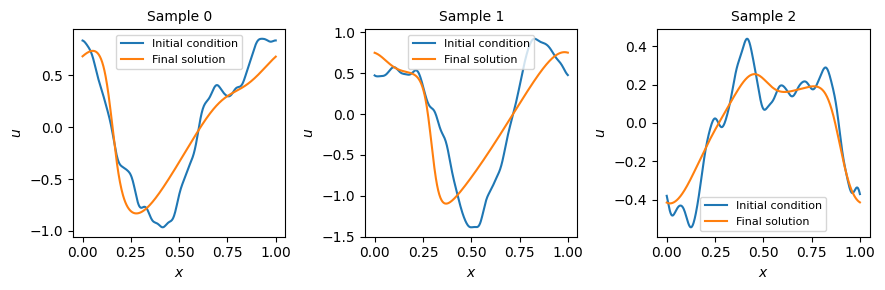

In [26]:
from matplotlib import pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9,3), layout='tight')

sample = 0
x = train_ds['input'][sample, 1, :]
u0 = train_ds['input'][sample, 0, :]
uf = train_ds['output'][sample, 0, :]
ax0.plot(x, u0, label='Initial condition')
ax0.plot(x, uf, label='Final solution')
ax0.legend(fontsize=8)
ax0.set_title(f'Sample {sample}', fontsize=10)
ax0.set_xlabel('$x$', fontsize=10)
ax0.set_ylabel('$u$', fontsize=10)

sample = 1
x = train_ds['input'][sample, 1, :]
u0 = train_ds['input'][sample, 0, :]
uf = train_ds['output'][sample, 0, :]
ax1.plot(x, u0, label='Initial condition')
ax1.plot(x, uf, label='Final solution')
ax1.legend(fontsize=8)
ax1.set_title(f'Sample {sample}', fontsize=10)
ax1.set_xlabel('$x$', fontsize=10)
ax1.set_ylabel('$u$', fontsize=10)

sample = 2
x = train_ds['input'][sample, 1, :]
u0 = train_ds['input'][sample, 0, :]
uf = train_ds['output'][sample, 0, :]
ax2.plot(x, u0, label='Initial condition')
ax2.plot(x, uf, label='Final solution')
ax2.legend(fontsize=8)
ax2.set_title(f'Sample {sample}', fontsize=10)
ax2.set_xlabel('$x$', fontsize=10)
ax2.set_ylabel('$u$', fontsize=10)

plt.show()

## 2.2 Define a dataset iterator

In [27]:
from typing import Dict

class DatasetIterator:
    def __init__(self, dataset: Dict[str, jnp.ndarray], batch_size: int, shuffle: bool = True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_samples = dataset['input'].shape[0]
        self.reset()
    
    def reset(self, key = jax.random.key(0)):
        """Reset the iterator to the beginning with optional reshuffling."""
        self.indices = jnp.arange(self.n_samples)
        if self.shuffle:
            self.indices = jnp.array(jax.random.permutation(key, self.indices))
        self.current_idx = 0
    
    def __iter__(self):
        return self
    
    def __next__(self) -> Dict[str, jnp.ndarray]:
        if self.current_idx >= self.n_samples:
            raise StopIteration
        
        start_idx = self.current_idx
        end_idx = min(start_idx + self.batch_size, self.n_samples)
        
        batch_indices = self.indices[start_idx:end_idx]
        
        batch = {
            'input': self.dataset['input'][batch_indices],
            'output': self.dataset['output'][batch_indices]
        }
        
        self.current_idx = end_idx
        return batch
    
    def __len__(self):
        return (self.n_samples + self.batch_size - 1) // self.batch_size

## 3. Create an `FNO1D` model instance

In [28]:
key = jax.random.key(0)
input_dim = 2
output_dim = 1   
model = jax_fno.FNO1D(
    key,
    input_dim, 
    output_dim, 
    width=64, 
    n_modes=12, 
    n_layers=4, 
    projection_hidden=128,
)

In [29]:
# Display the model
nnx.display(model)

In [18]:
# Check the model works for a forward pass
x = train_ds['input'][:2, :, :]
y = model(x)

## 4. Create the optimiser and define metrics

In [19]:
# Create optimiser with exponentially decaying learning rate
learning_rate = 1e-3  # initial learning rate

# Calculate steps per epoch for proper scheduling
n_train = train_ds['input'].shape[0]
batch_size = 20
steps_per_epoch = (n_train + batch_size - 1) // batch_size  # ceil division

# Schedule that changes every 100 epochs
schedule = optax.schedules.exponential_decay(
    learning_rate, 
    transition_steps=steps_per_epoch * 100,  # 100 epochs worth of steps
    decay_rate=0.5, 
    staircase=True
)

optimizer = nnx.Optimizer(model, optax.adam(schedule), wrt=nnx.Param)
metrics = nnx.MultiMetric(loss=nnx.metrics.Average('loss'),)

## 5. Define training step functions

In [20]:
def l2norm_loss(predictions: jax.Array, targets: jax.Array) -> jax.Array:
    errors = jnp.linalg.norm(targets - predictions, axis=-1) / jnp.linalg.norm(targets, axis=-1)
    return jnp.mean(errors)


def loss_fn(
    model: jax_fno.FNO1D, 
    batch_input: jax.Array, 
    batch_output: jax.Array
):
    """
    Loss function for the model.
    
    Args:
        model: FNO model
        batch_input: Input batch of shape (batch_size, n_points, 2)
        batch_output: Target batch of shape (batch_size, n_points, 1)
    """
    predictions = model(batch_input)
    return l2norm_loss(predictions, batch_output)


@nnx.jit
def train_step(
        model: jax_fno.FNO1D,
        optimizer: nnx.Optimizer,
        metrics: nnx.MultiMetric,
        batch_input: jax.Array,
        batch_output: jax.Array
    ):
    """Single training step."""
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model, batch_input, batch_output)
    metrics.update(loss=loss)  # In-place updates
    optimizer.update(model, grads)  # In-place updates


@nnx.jit
def eval_step(
        model: jax_fno.FNO1D,
        metrics: nnx.MultiMetric,
        batch_input: jax.Array,
        batch_output: jax.Array
    ):
    loss = loss_fn(model, batch_input, batch_output)
    metrics.update(loss=loss)  # In-place updates

## 6. Train and evaluate the model

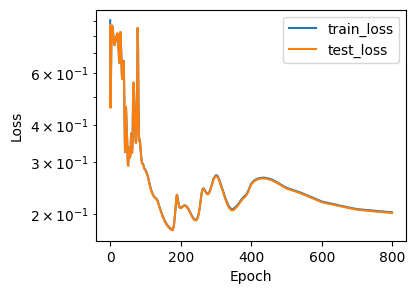

In [30]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

metrics_history = {'train_loss': [], 'test_loss': []}
n_epochs = 800

train_iter = DatasetIterator(train_ds, batch_size=batch_size, shuffle=True)
test_iter = DatasetIterator(test_ds, batch_size=batch_size, shuffle=False)

shuffle_key = jax.random.key(42)

for epoch in range(1, n_epochs+1):
	model.train()
	for batch in train_iter:
		train_step(model, optimizer, metrics, batch['input'], batch['output'])
	shuffle_key, subkey = jax.random.split(shuffle_key)
	train_iter.reset(subkey)
	
	metrics_history['train_loss'].append(metrics.compute()["loss"])

	# Evaluation
	model.eval()
	for batch in test_iter:
		eval_step(model, metrics, batch["input"], batch["output"])
	shuffle_key, subkey = jax.random.split(shuffle_key)
	test_iter.reset(subkey)
	metrics_history["test_loss"].append(metrics.compute()["loss"])
		
	# Reset the metrics before the next training epoch
	metrics.reset()

	# Plot loss
	clear_output(wait=True)
	fig, ax = plt.subplots(figsize=(4, 3))
	ax.set_xlabel('Epoch')
	ax.set_ylabel('Loss')
	ax.set_yscale('log')
	ax.plot(metrics_history[f'train_loss'], label=f'train_loss')
	ax.plot(metrics_history[f'test_loss'], label=f'test_loss')
	ax.legend()
	plt.show()

## 7. Perform inference on the test set

In [31]:
model.eval()  # switch to evaluation mode

@nnx.jit
def pred_step(model: jax_fno.FNO1D, batch_input: jax.Array):
  return model(batch_input)

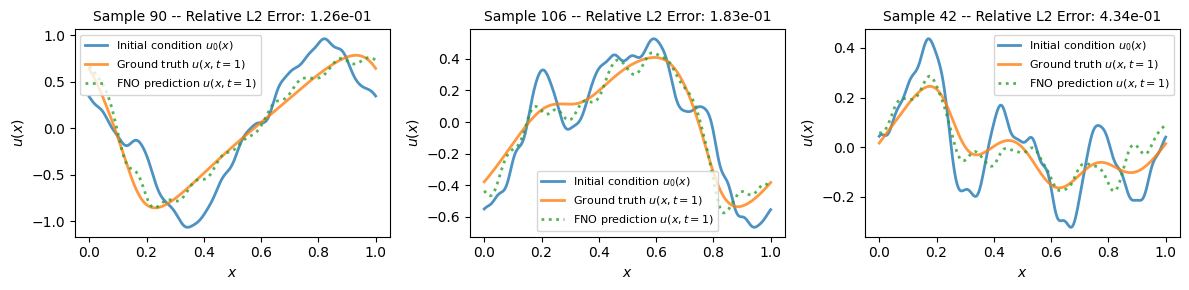

In [32]:
import numpy as np

n_examples = 3
    
n_test = test_ds['input'].shape[0]
example_indices = np.random.choice(n_test, size=min(n_examples, n_test), replace=False)
    
# Get predictions for selected examples
selected_inputs = test_ds['input'][example_indices]
selected_outputs = test_ds['output'][example_indices]
predictions = model(selected_inputs)

# Create subplots
fig, axes = plt.subplots(1, n_examples, figsize=(3*4, 3), layout='tight')
if n_examples == 1:
    axes = [axes]

for i, (ax, idx) in enumerate(zip(axes, example_indices)):
    # Extract data for this example
    x = selected_inputs[i, 1, :]
    u0 = selected_inputs[i, 0, :]  # Initial condition
    u_true = selected_outputs[i, 0, :]  # Ground truth final state
    u_pred = predictions[i, 0, :]  # Model prediction
    
    # Plot
    ax.plot(x, u0, '-', label='Initial condition $u_0(x)$', linewidth=2, alpha=0.8)
    ax.plot(x, u_true, '-', label='Ground truth $u(x,t=1)$', linewidth=2, alpha=0.8)
    ax.plot(x, u_pred, ':', label='FNO prediction $u(x,t=1)$', linewidth=2, alpha=0.8)
    
    # Compute error metrics
    l2_error = jnp.linalg.norm(u_pred - u_true) / jnp.linalg.norm(u_true)
    
    ax.set_title(f'Sample {idx+1} -- Relative L2 Error: {l2_error:.2e}', fontsize=10)
    ax.set_xlabel('$x$', fontsize=10)
    ax.set_ylabel('$u(x)$', fontsize=10)
    ax.legend(fontsize=8)
    # ax.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()

## 8. Save the trained FNO model

In [ ]:
# ckpt_dir = None
# checkpointer = ocp.StandardCheckpointer()
# _, state = nnx.split(model)
# checkpointer = ocp.StandardCheckpointer()
# checkpointer.save(ckpt_dir / 'state', state)
# print(f"Model saved to: {ckpt_dir}")